# Оптимизация производственных расходов при обработке стали (Промышленность)

Металлургический комбинат ООО «Так закаляем сталь» решил оптимизировать производственные расходы, путем уменьшения потребления электоэнергии на этапе обработки стали.

Перед нами стоит задача построить модель, которая предскажет температуру стали.

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

**План проекта**

В процесссе работы над проектом мы выполним следующие этапы работ:
1) загрузим данные и проведем их первичный осмотр: наличие пропусков и дубликатов, проверим тип данных, количество уникальных значений (при необходимости) и посмотрим статистические данные по всем таблицам.

2) проведем предобработку данных:
- исправим названия столбцов
- заменим пропуски на нули в таблицах с данными о сыпучих материалах и проволоки
- сгруппируем таблицу с данными по мощности по номеру партии. Выведим время начала нагрева и конца в отдельных столбцах. Расчитаем суммарное время нагрева. Посчитаем количество затраченной электроэнергии, предварительно убрав из данных аномальные значения реактивной мощности.
- сгруппируем таблицу с данными по температуре по номеру партии. В отдельные столбцы выведем начальное время и конечное по партии, а также начальную и конечную температуру. Затем посмотрим есть ли строки с пропусками в начальной и конечной температуре. Удалим партии, где начальное время равно конечному.
- в таблицах с данными по времени добавления сыпучих материалов и проволоки найдем последнее время по партии. 
- создадим список партий в которых после последнего замера температуры нет бульше никаких операций.
- посмотрим выбросы в таблице с температурой (окончательное решение по этому пункту пока не прияно, пока не знаю, отбрасывать выбросы или пометить, как обсуждали на консультации)

3) подготовим сводную таблицу для моделирования на основании сгруппированных таблиц и списка партий, где замер температуры является последней операцией. Разделим данные на две выборки: обучающую и тестовую. 
- в обучающей выборке посмотрим распределение и отбросим выбросы при необходимости.
- поскольку я собираюсь стоить модели чувствительные к масштабу, то проведем масштабирование признаков.


4) разделим данные на признаки и целевой признак. Обучим 4-6 моделей. В процессе постараемся подобрать оптимальные гиперпараметры и применим кросс-валидацию.

5) оценим качество модели с помощью метрики MAE на тестовой выборке.

6) напишем общий вывод по проекту.
 

 

## Подготовка данных

### Загрузка файлов и изучение информации

Загрузим все необходимые библиотеки.

In [1]:
!pip install shap

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns



from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer 
from sklearn.preprocessing import StandardScaler


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor




from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import shap

После загрузки каждого файла, нам необходимо будет посмотреть информацию о нем:
- напечатать первые 10 строк, чтобы зрительно оценить содержимое;
- посмотреть информацию о самом файле;
- проверить есть ли пропуски и дубликаты.

И для этого напишем функцию:

In [3]:
def info_file(df):
    display(df.head(10))
    print()
    print()
    print('Информация о файле:')
    print(df.info())
    print()
    print()
    print('Количество пропусков по столбцам:')
    print(df.isna().sum())
    print()
    print()
    print('Количество дубликатов:', df.duplicated().sum())
    
    
    return

Далее загрузим все файли и изучим информацию в них.

In [4]:

try:
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv', parse_dates = [1,2]) # загрузка данных
except:
    data_arc = pd.read_csv('C:\\Users\\koten\\Documents\\Яндекс практикум\\Финальный проект\\final_steel\\final_steel\\data_arc.csv', parse_dates = [1,2]) # загрузка данных

In [5]:
info_file(data_arc)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494




Информация о файле:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB
None


Количество пропусков по столбцам:
key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64


Количество дубликатов: 0


По первым 10 строкам явных ошибок не обнаружено. Единственное, на что стоит обратить внимание - это то, что названия столбцов на русском языке, но это мы исправим, когда будем делать предобработку данных. Дубликатов и пропусков не обнаружено. В файле 5 столбцов: у одного тип int64, у двух - datetime64 и еще у двух -float64. Столбцы с датами мы преобразовали в формат datetime64 при загрузке. Посмотрим, сколько уникальных номеров партий у нас есть:

In [6]:
len(data_arc['key'].unique()) # количество уникальных значений

3214

In [7]:
data_arc['Реактивная мощность'].sort_values().unique()

array([-7.15504924e+02,  2.08063126e-02,  2.11541653e-02, ...,
        2.45995915e+00,  2.50420606e+00,  2.67638755e+00])

Далее посмотрим статистические данные по таблице

In [8]:
data_arc.describe() # просмотр статистических данных

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


Мы видим, что у активной и реактивной мощностей есть значения, которые находятся очень далеко от минимума и максимума, вероятнее всего это выбросы. Данные по активной и реактивной мощностям скошены вправо (медиана меньше среднего), при этом смещение у реактивной мощности совсем незначительное.

Далее посмотри загрузим и посмотри данные о подаче сыпучих материалов.

In [9]:
try:
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv') # загрузка данных
except:
    data_bulk = pd.read_csv('C:\\Users\\koten\\Documents\\Яндекс практикум\\Финальный проект\\final_steel\\final_steel\\data_bulk.csv')

In [10]:
info_file(data_bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0




Информация о файле:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None


Количество пропусков по столбцам:
key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     30

В таблице 16 столбцов: один имеет формат int64 (это столбец с номером партии) и 15 столбцов с форматом float64, в которых указано количество сыпучих веществ. Названия столбцов лучше написать прописными буквами через подчеркивание. Дубликатов у нас нет. Но зато достаточно много пропущенных значений. Вероятнее всего, что сыпучие вещеста просто не добавлялись из конкретного бункера для разных партий стали. Такие значения мы можем заменить на ноль.

In [11]:
len(data_bulk['key'].unique()) # общее количество уникальных значений

3129

Количество уникальных значений партий больше, чем в файле с электродами.

In [12]:
data_bulk.describe() # просмотр статистических данных

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Данные распределены со смещение вправо (медиана меньше среднего).

Посмотрим данные о времени подачи сыпучих материалов.

In [13]:
try:
    data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv', parse_dates = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]) # загрузка данных
except:
    data_bulk_time = pd.read_csv('C:\\Users\\koten\\Documents\\Яндекс практикум\\Финальный проект\\final_steel\\final_steel\\data_bulk_time.csv', parse_dates = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])

In [14]:
info_file(data_bulk_time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaT,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaT,NaT,NaT,2019-05-03 13:18:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaT,NaT,NaT,2019-05-03 13:59:24,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:53:27,NaT,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaT,NaT,NaT,2019-05-03 14:29:14,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 14:22:19,NaT,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaT,NaT,NaT,2019-05-03 15:04:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 14:55:46,NaT,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaT,NaT,NaT,2019-05-03 15:47:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 15:41:00,NaT,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 16:18:52,NaT,2019-05-03 16:18:52,2019-05-03 16:18:52




Информация о файле:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB
N

В таблице 16 столбцов: один имеет формат int64 (это столбец с номером партии) и 15 столбцов с форматом datetime64, в которых указано время добавления сыпучих веществ. Названия столбцов лучше написать прописными буквами через подчеркивание. Дубликатов у нас нет. Пропуски заменять не будем

In [15]:
len(data_bulk_time['key'].unique()) # общее количество уникальных значений

3129

Количество уникальных значений партий сохранилось таким же, как и в таблице, где указано количество добавленных сухих вещест.

Загрузим и посмотрим таблицу с данными о продувке сплава газом.

In [16]:
try:
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv') # загрузка данных
except:
    data_gas = pd.read_csv('C:\\Users\\koten\\Documents\\Яндекс практикум\\Финальный проект\\final_steel\\final_steel\\data_gas.csv')

In [17]:
info_file(data_gas)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891




Информация о файле:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None


Количество пропусков по столбцам:
key      0
Газ 1    0
dtype: int64


Количество дубликатов: 0


In [18]:
data_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [19]:
len(data_gas['key'].unique()) # общее количество уникальных значений

3239

В таблице всего два столбца. У первого тип int64 и это номер партии, а второй имеет тип float64 и содержит информацию об объеме газа для продувки сплава. Данные распределены со смещением вправо (медиана меньше среднего). Название столбца необходимо привести к единому стандарту написания (на англ.языке прописными буквами). Пропусков и дубликатов в таблице нет. Количество уникальных номеров партий больше, чем в предыбущих таблицах. 

Далее следует таблица с данными о результатах измерения температуры:

In [20]:
try:
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv', parse_dates = [1]) # загрузка данных
except:
    data_temp = pd.read_csv('C:\\Users\\koten\\Documents\\Яндекс практикум\\Финальный проект\\final_steel\\final_steel\\data_temp.csv', parse_dates = [1])

In [21]:
info_file(data_temp)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0




Информация о файле:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   Время замера  15907 non-null  datetime64[ns]
 2   Температура   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB
None


Количество пропусков по столбцам:
key                0
Время замера       0
Температура     2901
dtype: int64


Количество дубликатов: 0


In [22]:
data_temp.describe()

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


In [23]:
len(data_temp['key'].unique()) # общее количество уникальных значений

3216

В таблице три столбца:
- номер партии (тип данных -  int64)
- время замера температуры (тип datetime64)
- температура (тип данных - float64)

Данные распределены нормально, но желательно проверить нет ли выбросов. Наименовния столбцов нужно привести к единому формату. В таблице есть пропуски в столбце с температурой. Необходимо определить пропуски измерений в промежуточных стадиях или пропуски там, где должны быть данные о температуре по окончанию процесса обработки партии стали. По количеству уникальных номеров, видно что не по всем партиям есть измерения температуры. Партии по которым нет измерений температуры или нет измерения по окончанию процесса нужно будет удалить.

Посмотрим данные из таблицы с объемом проволочных материалов.

In [24]:
try:
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv') # загрузка данных
except:
    data_wire = pd.read_csv('C:\\Users\\koten\\Documents\\Яндекс практикум\\Финальный проект\\final_steel\\final_steel\\data_wire.csv')

In [25]:
info_file(data_wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN




Информация о файле:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None


Количество пропусков по столбцам:
key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64


Количество дубликатов: 0


In [26]:
data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [27]:
len(data_wire['key'].unique()) # общее количество уникальных значений

3081

В таблице 10 столбцов: первый - это номер партии (тип данных - int64 и в девяти данные о количестве проволочных материалов (тип данных - float64). Данные как и в предыдущих таблицах скошены вправо. Дубликатов строк нет. Есть пропуски, но они как и пропуски в таблице с сыпучими материалами, объясняются тем, что определеный вид проволоки не добавляли на каких-то этапах обработки. Более того, даже не во все партии сплава добавляли проволоку (количество уникальных значений партий меньше, чем во всех остальных таблицах).

Последней мы разберем таблицу с данными о времени добавления проволочных материалов в справ.

In [28]:
try:
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv', parse_dates = [1,2,3,4,5,6,7,8,9]) # загрузка данных
except:
    data_wire_time = pd.read_csv('C:\\Users\\koten\\Documents\\Яндекс практикум\\Финальный проект\\final_steel\\final_steel\\data_wire_time.csv',  parse_dates = [1,2,3,4,5,6,7,8,9])

In [29]:
info_file(data_wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:48:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaT,NaT,NaT,NaT,NaT,NaT,NaT
6,7,2019-05-03 14:28:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
7,8,2019-05-03 15:03:42,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaT,NaT,NaT,NaT,NaT,NaT,NaT
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaT,NaT,NaT,NaT,NaT,NaT,NaT




Информация о файле:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB
None


Количество пропусков по столбцам:
key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64


Количество дубликатов: 0


In [30]:
len(data_wire_time['key'].unique()) # общее количество уникальных значений

3081

В таблице 10 столбцов: первый - это номер партии (тип данных - int64 и в девяти данные о времени добавления проволочных материалов (тип данных - datetime64). Дубликатов строк нет. Пропуски заменять мы не будем. 

**Вывод**

В первом разделе проекта мы загрузили данные и провели первичный их осмотр. На этом этапе были выявлены следующие моменты:
- все таблицы требуют приведения наименования столбцов к единому формату.
- количество уникальных номеров партий в таблицах разное
- данные, кроме таблиц во временем добавления сыпучих материалов и проволоки, имеют положительную скощенность
- в таблицах с мощностями и температурами явно есть выбросы, которые нужно будет обработать перед построением модели
- не для всех партий есть измерение температуры по завершению процесса. Такие партии нужно будет удалить. Как в принципе и те, у которых вообще нет измерений температуры.
- поскольку мы сразу при загрузке определили, что даты и время должны загружаться в формате datetime64, то корретировки типа данных в таблицах не требуется.


### Предобработка и анализ данных

В первую очередь приведем названия столбцов к единому формату.

In [31]:
data_arc = data_arc.rename(columns = {'Начало нагрева дугой': 'start_heating', 'Конец нагрева дугой': 'finish_heating', 
                                      'Активная мощность': 'active_power', 'Реактивная мощность': 'reactive_power'})

data_bulk = data_bulk.rename(columns = {'Bulk 1': 'bulk_1', 'Bulk 2': 'bulk_2', 'Bulk 3': 'bulk_3', 'Bulk 4': 'bulk_4',
                                        'Bulk 5': 'bulk_5', 'Bulk 6': 'bulk_6', 'Bulk 7': 'bulk_7', 'Bulk 8': 'bulk_8', 
                                        'Bulk 9': 'bulk_9', 'Bulk 10': 'bulk_10', 'Bulk 11': 'bulk_11', 'Bulk 12': 'bulk_12',
                                        'Bulk 13': 'bulk_13', 'Bulk 14': 'bulk_14', 'Bulk 15': 'bulk_15'})
    
data_bulk_time = data_bulk_time.rename(columns = {'Bulk 1': 'bulk_1', 'Bulk 2': 'bulk_2', 'Bulk 3': 'bulk_3', 'Bulk 4': 'bulk_4',
                                        'Bulk 5': 'bulk_5', 'Bulk 6': 'bulk_6', 'Bulk 7': 'bulk_7', 'Bulk 8': 'bulk_8', 
                                        'Bulk 9': 'bulk_9', 'Bulk 10': 'bulk_10', 'Bulk 11': 'bulk_11', 'Bulk 12': 'bulk_12',
                                        'Bulk 13': 'bulk_13', 'Bulk 14': 'bulk_14', 'Bulk 15': 'bulk_15'})
    
data_gas = data_gas.rename(columns = {'Газ 1': 'gas_1'})
    
data_temp = data_temp.rename(columns = {'Время замера': 'measurement_time', 'Температура': 'temperature'})
    
data_wire = data_wire.rename(columns = {'Wire 1': 'wire_1', 'Wire 2': 'wire_2', 'Wire 3': 'wire_3', 'Wire 4': 'wire_4',
                                        'Wire 5': 'wire_5', 'Wire 6': 'wire_6', 'Wire 7': 'wire_7', 'Wire 8': 'wire_8',
                                        'Wire 9': 'wire_9'}) 
    
data_wire_time = data_wire_time.rename(columns = {'Wire 1': 'wire_1', 'Wire 2': 'wire_2', 'Wire 3': 'wire_3', 'Wire 4': 'wire_4',
                                        'Wire 5': 'wire_5', 'Wire 6': 'wire_6', 'Wire 7': 'wire_7', 'Wire 8': 'wire_8',
                                        'Wire 9': 'wire_9'})

In [32]:
print(data_arc.columns)

print(data_bulk.columns)

print(data_bulk_time.columns)

print(data_gas.columns)

print(data_temp.columns)

print(data_wire.columns)

print(data_wire_time.columns)


Index(['key', 'start_heating', 'finish_heating', 'active_power',
       'reactive_power'],
      dtype='object')
Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')
Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')
Index(['key', 'gas_1'], dtype='object')
Index(['key', 'measurement_time', 'temperature'], dtype='object')
Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')
Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')


Теперь заменим пропуски в таблицах с данными об объеме сыпучих материалов и проволоки на ноль.

In [33]:
data_bulk = data_bulk.fillna(0)

data_wire = data_wire.fillna(0)


Проверим, что пропусков не осталось.

In [34]:
print(data_bulk.isna().sum())
print()
print(data_wire.isna().sum())



key        0
bulk_1     0
bulk_2     0
bulk_3     0
bulk_4     0
bulk_5     0
bulk_6     0
bulk_7     0
bulk_8     0
bulk_9     0
bulk_10    0
bulk_11    0
bulk_12    0
bulk_13    0
bulk_14    0
bulk_15    0
dtype: int64

key       0
wire_1    0
wire_2    0
wire_3    0
wire_4    0
wire_5    0
wire_6    0
wire_7    0
wire_8    0
wire_9    0
dtype: int64


#### Предобработка данных об электродах

В данных по реактивной мощности встречалось аномальное значение -715. Все остальные числа находятся в диапазоне от 0 до 3. Удалим строку с аномальным значением.

In [35]:
list_1 = data_arc.loc[data_arc['reactive_power'] < 0].index.tolist()
data_arc = data_arc.drop(data_arc.index[list_1], axis = 0)

In [36]:
print(data_arc['reactive_power'].min())

0.0208063126


Явно аномальное значение удалено. 

В таблице с электродами по каждой строке посчитаем время между началом и концом нагрева. Это нужно для того, чтобы в сводной таблице можно было посчитать суммарное количество, затраченной электроэнергии.

In [37]:
data_arc['heating_time'] = (data_arc['finish_heating'] - data_arc['start_heating']).astype('timedelta64[s]')


Посчитаем количество электроэнергии по каждому столбцу. Для этого полную мощность (кв.корень из суммы квадратов активной и реактивной мощностей) умножим на время.

In [38]:
data_arc['energy_consument'] = (np.sqrt((data_arc['active_power']**2) + (data_arc['reactive_power']**2))) *\
data_arc['heating_time']

In [39]:
display(data_arc.head())

,key,start_heating,finish_heating,active_power,reactive_power,heating_time,energy_consument
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228.0,272.149755
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185.0,177.416785
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172.0,154.118502
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365.0,719.221394
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148.0,119.471318


Сгруппируем таблицу по номеру партии так, чтобы в строке отражалось первое и последнее время нагрева, средняя мощность, сумма времени и сумма затраченной электроэнергии.

In [40]:
data_arc = data_arc.groupby('key', as_index=False).agg({'start_heating': 'first', 'finish_heating': 'last',
                                                        'active_power' : 'mean', 'reactive_power' : 'mean', 
                                                        'heating_time': 'sum', 'energy_consument': 'sum'})

In [41]:
display(data_arc.head())

,key,start_heating,finish_heating,active_power,reactive_power,heating_time,energy_consument
0,1,2019-05-03 11:02:14,2019-05-03 11:28:37,0.975629,0.636648,1098.0,1442.377754
1,2,2019-05-03 11:34:14,2019-05-03 11:53:18,0.763150,0.499528,811.0,881.233565
2,3,2019-05-03 12:06:54,2019-05-03 12:32:19,0.505176,0.319815,655.0,525.066777
3,4,2019-05-03 12:39:37,2019-05-03 12:57:50,0.802313,0.515074,741.0,796.911309
4,5,2019-05-03 13:11:13,2019-05-03 13:33:55,0.836793,0.563161,869.0,1199.137958


In [42]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               3214 non-null   int64         
 1   start_heating     3214 non-null   datetime64[ns]
 2   finish_heating    3214 non-null   datetime64[ns]
 3   active_power      3214 non-null   float64       
 4   reactive_power    3214 non-null   float64       
 5   heating_time      3214 non-null   float64       
 6   energy_consument  3214 non-null   float64       
dtypes: datetime64[ns](2), float64(4), int64(1)
memory usage: 175.9 KB


Посмотрим характерный разброс активной и реактивной мощностей.

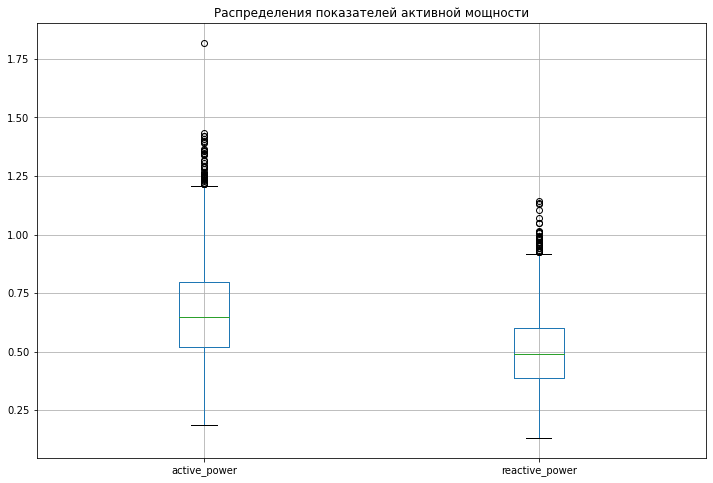

In [43]:
data_arc.boxplot(column=['active_power', 'reactive_power'], grid = True, figsize =(12, 8))
plt.title('Распределения показателей активной мощности')
plt.show()

В данных по мощностям есть выбросы. Возможно было необходимо очень быстро нагреть кофш и подключали дополнительные источники электроэнергии. На данный момент у нас нет возможности обратится с энергетику предприятия и уточнить информацию по данному вопросу.

Посмотрим характерный расброс по потребленной электроэнергии.

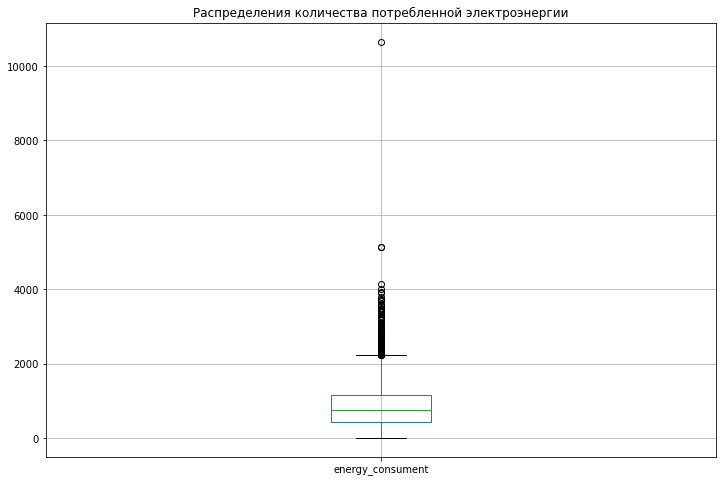

In [44]:
data_arc.boxplot(column = 'energy_consument', grid = True, figsize =(12, 8))
plt.title('Распределения количества потребленной электроэнергии')
plt.show()

Достаточно большое количество значений находится в интервале от 2100 до 4000. Но есть несколько очень больших показателей. Посмотрим на них:

In [45]:
display(data_arc.loc[data_arc['energy_consument'] > 4000])
list_abnormal_energy = (data_arc.loc[data_arc['energy_consument'] > 4000]).index.tolist()
print(list_abnormal_energy)

,key,start_heating,finish_heating,active_power,reactive_power,heating_time,energy_consument
43,46,2019-05-04 23:46:31,2019-05-05 03:08:57,0.950894,0.643838,2919.0,4000.284839
629,640,2019-05-27 01:21:13,2019-05-27 02:05:50,1.221247,0.896421,1917.0,4153.644335
1672,1689,2019-07-02 15:25:34,2019-07-02 21:56:59,1.166433,0.839199,4189.0,10630.980668
1863,1880,2019-07-09 05:54:14,2019-07-09 09:10:30,1.035246,0.896949,2755.0,5134.427712
1984,2001,2019-07-19 20:14:38,2019-07-19 22:35:45,1.319270,0.954014,2065.0,5123.890430


[43, 629, 1672, 1863, 1984]


В этих строках мощность находится в нормальных пределах, но время нагрева очень большое. Нужно будет посмотреть эти партии в таблице с температурой.

#### Предобработка данных о сыпучих материалах и проволоке

Поскольку у нас одна строка - это одна партия, то просто сгруппируем по номеру партии, чтобы во всех столбцах получилась сумма сыпучих веществ, затраченных на каждую партию стали.

In [46]:
data_bulk = data_bulk.groupby('key', as_index=False).sum()

In [47]:
display(data_bulk.head())

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


Аналогично поступим с данными о проволоке: сгруппируем по номеру партии, посчитав сумму по столбцам.

In [48]:
data_wire = data_wire.groupby('key', as_index=False).sum()

In [49]:
display(data_wire.head())

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


В связи с тем, что нам нужно будет проверить и убедиться, что последний замер температуры произведен по окончанию производственного процесса, возникает необходимость проверить время последнего добавления сухих материалов и проволоки. В итоге я хочу отобрать только те партии, где время замера температуры больше времени последнего нагрева, и последнего добавления материалов.

Для того, чтобы решить эту задачу, нам понадобится преобразовать таблицы со временем добавления сухих веществ и проволоки. В результате мы получим таблицу, в которой будет номер партии и последнее время добавления материалов.

In [50]:
data_wire_time['wire_max_tame'] = data_wire_time[['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9']].max(axis=1) 

data_wire_time_end = data_wire_time[['key', 'wire_max_tame']]

In [51]:
display(data_wire_time_end.head())

,key,wire_max_tame
0,1,2019-05-03 11:11:41
1,2,2019-05-03 11:46:10
2,3,2019-05-03 12:13:47
3,4,2019-05-03 12:48:05
4,5,2019-05-03 13:32:06


In [52]:
data_bulk_time['bulk_max_tame'] = data_bulk_time[['bulk_1','bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
                                             'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11',
                                             'bulk_12','bulk_13','bulk_14', 'bulk_15']].max(axis=1) 

data_bulk_time_end = data_bulk_time[['key', 'bulk_max_tame']]

In [53]:
display(data_bulk_time_end.head())

,key,bulk_max_tame
0,1,2019-05-03 11:21:30
1,2,2019-05-03 11:46:38
2,3,2019-05-03 12:31:06
3,4,2019-05-03 12:48:43
4,5,2019-05-03 13:18:50


#### Предобработка данных температуре

В таблице есть строки, где нет замеров температуры, но есть время. Такие строки мы удалим.

In [54]:
data_temp = data_temp.dropna(subset = ['temperature'])

Поскольку нам в данном случае не нужны промежуточные температуры, сгруппируем таблицу таким образом, чтобы у нас появились столбцы с первыми и последними значениями времени и температуры по каждой партии.

In [55]:
agg_data_temp = {'measurement_time': ['first', 'last'], 'temperature': ['first', 'last']}

data_temp = data_temp.groupby('key', as_index=False).agg(agg_data_temp)

data_temp.columns = ['key', 'measurement_time_first', 'measurement_time_last', 'temperature_first', 'temperature_last']


In [56]:
display(data_temp.head())

,key,measurement_time_first,measurement_time_last,temperature_first,temperature_last
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0


Проверим, есть ли у нас пропуски в итоговой таблице в столбцах с начальной и конечной температурой.

In [57]:
print(data_temp['temperature_last'].isna().sum())

0


In [58]:
print(data_temp['temperature_first'].isna().sum())

0


Пропусков нет. 

Если у нас было только одно измерение температуры в первоначальной таблице, то после того как мы удалили строки с пропусками, при группировке начальное время станет и конечным временем. Посмотрим есть ли строки, где время первого измерения температуры является и последним.

In [59]:
print(data_temp.loc[data_temp['measurement_time_first'] == data_temp['measurement_time_last']].index.tolist())

[192, 276, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510, 2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521, 2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532, 2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543, 2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2553, 2554, 2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620, 2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629, 2630, 2631, 2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2641,

Удалим эти партии.

In [60]:
list_bad_key = (data_temp.loc[data_temp['measurement_time_first'] == data_temp['measurement_time_last']]).index.tolist()


In [61]:
data_temp = data_temp.drop(data_temp.index[list_bad_key], axis = 0)

Посмотрим распределение начальных и конечных температур.


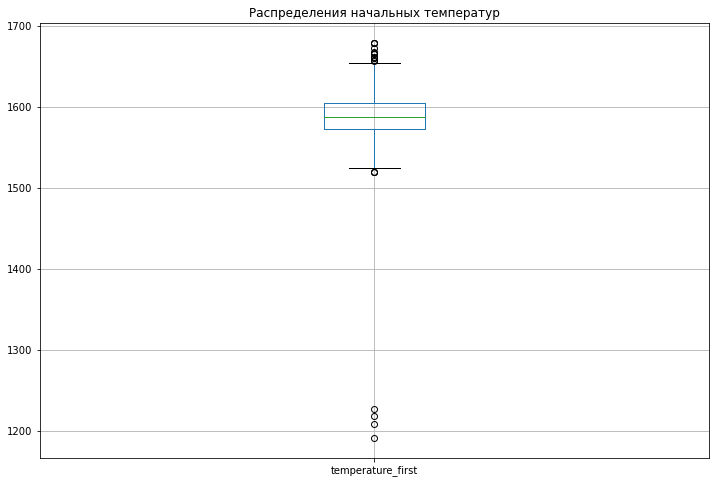

In [62]:
data_temp.boxplot(column='temperature_first', grid = True, figsize =(12, 8))

plt.title('Распределения начальных температур')
plt.show()

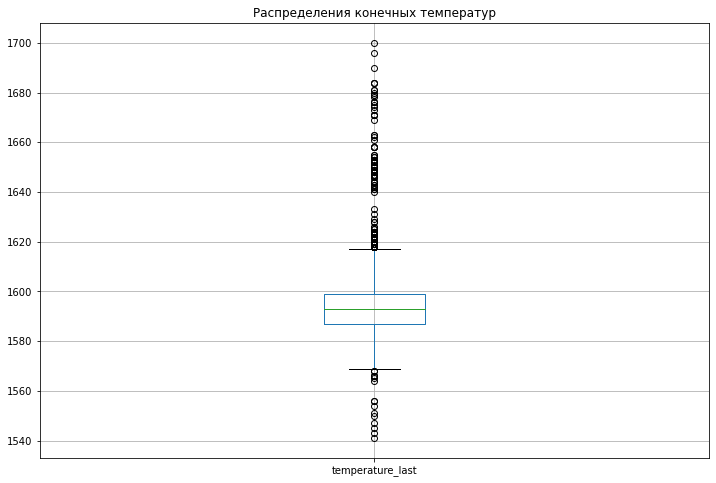

In [63]:
data_temp.boxplot(column = 'temperature_last', grid = True, figsize =(12, 8))
plt.title('Распределения конечных температур')
plt.show()

Есть несколько видов стали и температура плавления у них немного разная. В основном диапазон от 1450 до 1525, а некоторые до 1600 градусов Цельсия. Но есть виды которые плавятся при температуре 1350, а сталь из медноникелевого сплава имеет температуру плавления всего 1150 градусов. Поэтому все температуры ниже 1600 (но не ниже 1150) градусов будем считать нормальными, но пометим, что это другой тип стали. А вот температуры выше 1600 градусов вероятнее всего излишни, хотя тут тоже нужно смотреть сделан ли замер температуры действительно в самом начале процесса или значительно позже. Это важно, потому что в процессе обработки стали температуру увеличивают еще на 100-150 градусов. И таким образом, если первый замер температуры сделан в середине процесса плавки, то 1700 градусов может быть абсолютно нормальным значением.

Введем дополнительный столбик, в котором нулем отметим обычный вид стали с температурой плавления выше 1450 градусов, а единицей те позиции, где температура ниже этой отметки.

In [64]:
def steel_group(row):
    steel=row['temperature_first']
   
       
    if steel >= 1450:  
        return 0
    
    
    else:
        return 1
    
data_temp['type_steel'] = data_temp.apply(steel_group, axis=1)
display(data_temp.head(5))


,key,measurement_time_first,measurement_time_last,temperature_first,temperature_last,type_steel
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0,0
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0,0
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0,0
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0,0
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0,0


In [65]:
display(data_temp.loc[data_temp['type_steel']==1])

,key,measurement_time_first,measurement_time_last,temperature_first,temperature_last,type_steel
855,867,2019-06-04 14:21:00,2019-06-04 14:57:17,1191.0,1599.0,1
1201,1214,2019-06-16 05:32:00,2019-06-16 06:14:45,1208.0,1591.0,1
1604,1619,2019-06-30 11:03:54,2019-06-30 11:21:54,1218.0,1590.0,1
2036,2052,2019-07-21 14:51:40,2019-07-21 15:24:06,1227.0,1592.0,1


#### Сводная таблица (анализ и обработка)

Объединим все таблицы в одну. В качестве первой используем таблицу с температурой, поскольку именно в ней находится целевой признак. Тип присоединения применим how = 'left'.

In [66]:
summary_table = data_temp.merge(data_arc, on=['key'], how = 'left')
summary_table = summary_table.merge(data_gas, on=['key'], how = 'left')
summary_table = summary_table.merge(data_bulk, on=['key'], how = 'left')
summary_table = summary_table.merge(data_bulk_time_end, on=['key'], how = 'left')
summary_table = summary_table.merge(data_wire, on=['key'], how = 'left')
summary_table = summary_table.merge(data_wire_time_end, on=['key'], how = 'left')

In [67]:
pd.set_option('display.max_columns', None)
display(summary_table.head(2))

,key,measurement_time_first,measurement_time_last,temperature_first,temperature_last,type_steel,start_heating,finish_heating,active_power,reactive_power,heating_time,energy_consument,gas_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_max_tame,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_max_tame
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0,0,2019-05-03 11:02:14,2019-05-03 11:28:37,0.975629,0.636648,1098.0,1442.377754,29.749986,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,2019-05-03 11:21:30,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 11:11:41
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0,0,2019-05-03 11:34:14,2019-05-03 11:53:18,0.763150,0.499528,811.0,881.233565,12.555561,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,2019-05-03 11:46:38,96.052315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 11:46:10


Создадим список партий, где последнее измерение температуры, не является последей итерацией в процессе.

In [68]:
list_bad_key2 =[]
for i in range(len(summary_table)):
    if summary_table['measurement_time_last'][i] < (summary_table['finish_heating'][i] 
                                                    or summary_table['bulk_max_tame'][i]
                                                    or summary_table['wire_max_tame'][i]):
        list_bad_key2.append(i)
print(list_bad_key2)
    

[10, 37, 40, 48, 61, 66, 70, 78, 174, 176, 177, 179, 182, 209, 212, 216, 218, 263, 267, 288, 291, 292, 316, 320, 321, 437, 438, 441, 446, 449, 463, 464, 465, 484, 526, 552, 576, 577, 578, 580, 582, 583, 586, 605, 627, 630, 692, 718, 720, 728, 744, 772, 855, 856, 860, 864, 914, 915, 918, 920, 983, 1043, 1046, 1137, 1138, 1146, 1217, 1297, 1300, 1325, 1355, 1365, 1386, 1417, 1441, 1444, 1447, 1476, 1488, 1541, 1561, 1601, 1605, 1606, 1607, 1622, 1640, 1666, 1668, 1695, 1696, 1703, 1707, 1794, 1796, 1820, 1855, 1856, 1859, 1929, 1932, 1947, 1949, 1970, 1972, 1973, 1975, 1976, 1977, 2035, 2060, 2119, 2121, 2123, 2124, 2133, 2192, 2202, 2242, 2244, 2246, 2280, 2283, 2367, 2368, 2371, 2376, 2403, 2405, 2428, 2434]


Обнаружено несколько строк, где последнее измерение температуры, не является последней итерацией в процессе. Эти строки мы удалим.

In [69]:
summary_table = summary_table.drop(summary_table.index[list_bad_key2], axis = 0)

Еще у нас оставался незакрытым, вопрос про строки, гда очень большой расход электроэнергии. Теперь мы можем посмотреть полную информацию по этим партиям.

In [70]:
display(summary_table.iloc[list_abnormal_energy])

,key,measurement_time_first,measurement_time_last,temperature_first,temperature_last,type_steel,start_heating,finish_heating,active_power,reactive_power,heating_time,energy_consument,gas_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_max_tame,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_max_tame
46,49,2019-05-05 03:50:08,2019-05-05 04:27:11,1626.0,1588.0,0,2019-05-05 03:45:43,2019-05-05 03:47:49,0.443937,0.351294,126.0,71.330662,10.441228,0.0,0.0,0.0,0.0,0.0,157.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-05 04:04:30,39.312000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,2019-05-05 04:03:38
675,687,2019-05-28 17:08:56,2019-05-28 18:38:44,1629.0,1587.0,0,2019-05-28 17:06:04,2019-05-28 18:31:54,0.694672,0.496959,1170.0,1157.512825,22.911746,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,256.0,0.0,105.0,206.0,2019-05-28 18:34:01,137.919601,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,2019-05-28 18:23:27
1765,1782,2019-07-05 15:15:19,2019-07-05 15:32:36,1594.0,1595.0,0,2019-07-05 15:09:47,2019-07-05 15:30:51,0.443813,0.368336,549.0,442.639588,6.650435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,99.0,103.0,2019-07-05 15:12:12,99.169197,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,2019-07-05 15:17:22
1966,1983,2019-07-19 02:04:22,2019-07-19 03:07:50,1619.0,1623.0,0,2019-07-19 02:00:02,2019-07-19 03:03:41,1.006508,0.737421,1213.0,1938.038383,12.165221,0.0,0.0,0.0,127.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,420.0,0.0,192.0,207.0,2019-07-19 02:26:52,151.132797,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,2019-07-19 02:26:30
2095,2114,2019-07-23 23:32:33,2019-07-23 23:52:00,1585.0,1593.0,0,2019-07-23 23:28:08,2019-07-23 23:48:59,0.709397,0.502935,511.0,463.414129,11.867074,0.0,0.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,186.0,0.0,141.0,137.0,2019-07-23 23:44:42,45.121437,0.0,0.0,0.0,0.0,34.011124,0.0,0.0,0.0,2019-07-23 23:44:52


На первый взгляд кроме долгого нагрева других аномалий не видно. Прежде, чем принимать решение об удалении этих данных, желательно получить консультацию технолога.

Для построения модели нам не нужны все столбцы. Столбцы с датами мы можем удалить, а столбец с номером партии переведем в индекс. Удалять его не будем, потому, что если вдруг нужно будет найти информацию по конкретной партии, мы сможем это сделать по индексу.

In [71]:
summary_table = summary_table.drop(['measurement_time_first', 'measurement_time_last',
                                    'start_heating', 'finish_heating', 'bulk_max_tame',
                                    'wire_max_tame'], axis =1)
summary_table = summary_table.set_index('key')


In [72]:
display(summary_table.head())

,temperature_first,temperature_last,type_steel,active_power,reactive_power,heating_time,energy_consument,gas_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,0,0.975629,0.636648,1098.0,1442.377754,29.749986,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1581.0,1602.0,0,0.763150,0.499528,811.0,881.233565,12.555561,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1596.0,1599.0,0,0.505176,0.319815,655.0,525.066777,28.554793,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1601.0,1625.0,0,0.802313,0.515074,741.0,796.911309,18.841219,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1576.0,1602.0,0,0.836793,0.563161,869.0,1199.137958,5.413692,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
summary_table.isna().sum()

temperature_first     0
temperature_last      0
type_steel            0
active_power          0
reactive_power        0
heating_time          0
energy_consument      0
gas_1                 2
bulk_1               61
bulk_2               61
bulk_3               61
bulk_4               61
bulk_5               61
bulk_6               61
bulk_7               61
bulk_8               61
bulk_9               61
bulk_10              61
bulk_11              61
bulk_12              61
bulk_13              61
bulk_14              61
bulk_15              61
wire_1               94
wire_2               94
wire_3               94
wire_4               94
wire_5               94
wire_6               94
wire_7               94
wire_8               94
wire_9               94
dtype: int64

В сводной таблице есть пропуски. Заменим их на нули.

In [74]:
summary_table = summary_table.fillna(0)

Нам также необходимо удалить партии в которых не добавляли ни одной присадки.


In [75]:
list_bad_key3 = (summary_table.loc[(summary_table[['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4',
                                                 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8',
                                                 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
                                                 'bulk_13', 'bulk_14', 'bulk_15', 'wire_1',
                                                 'wire_2', 'wire_3', 'wire_4', 'wire_6', 'wire_7',
                                                 'wire_9']].sum(axis = 1)) == 0]).index.tolist()
print(list_bad_key3)

summary_table = summary_table.drop(summary_table.index[list_bad_key3], axis = 0)

[52, 53, 54, 55, 56, 269, 330, 331, 332, 931, 933, 1105, 1566, 1818, 1979, 2010, 2043, 2195, 2196, 2197, 2198, 2216, 2217]


Далее посмотрим корреляцию между столбцами таблицы

In [76]:
#summary_table.corr()

<AxesSubplot:>

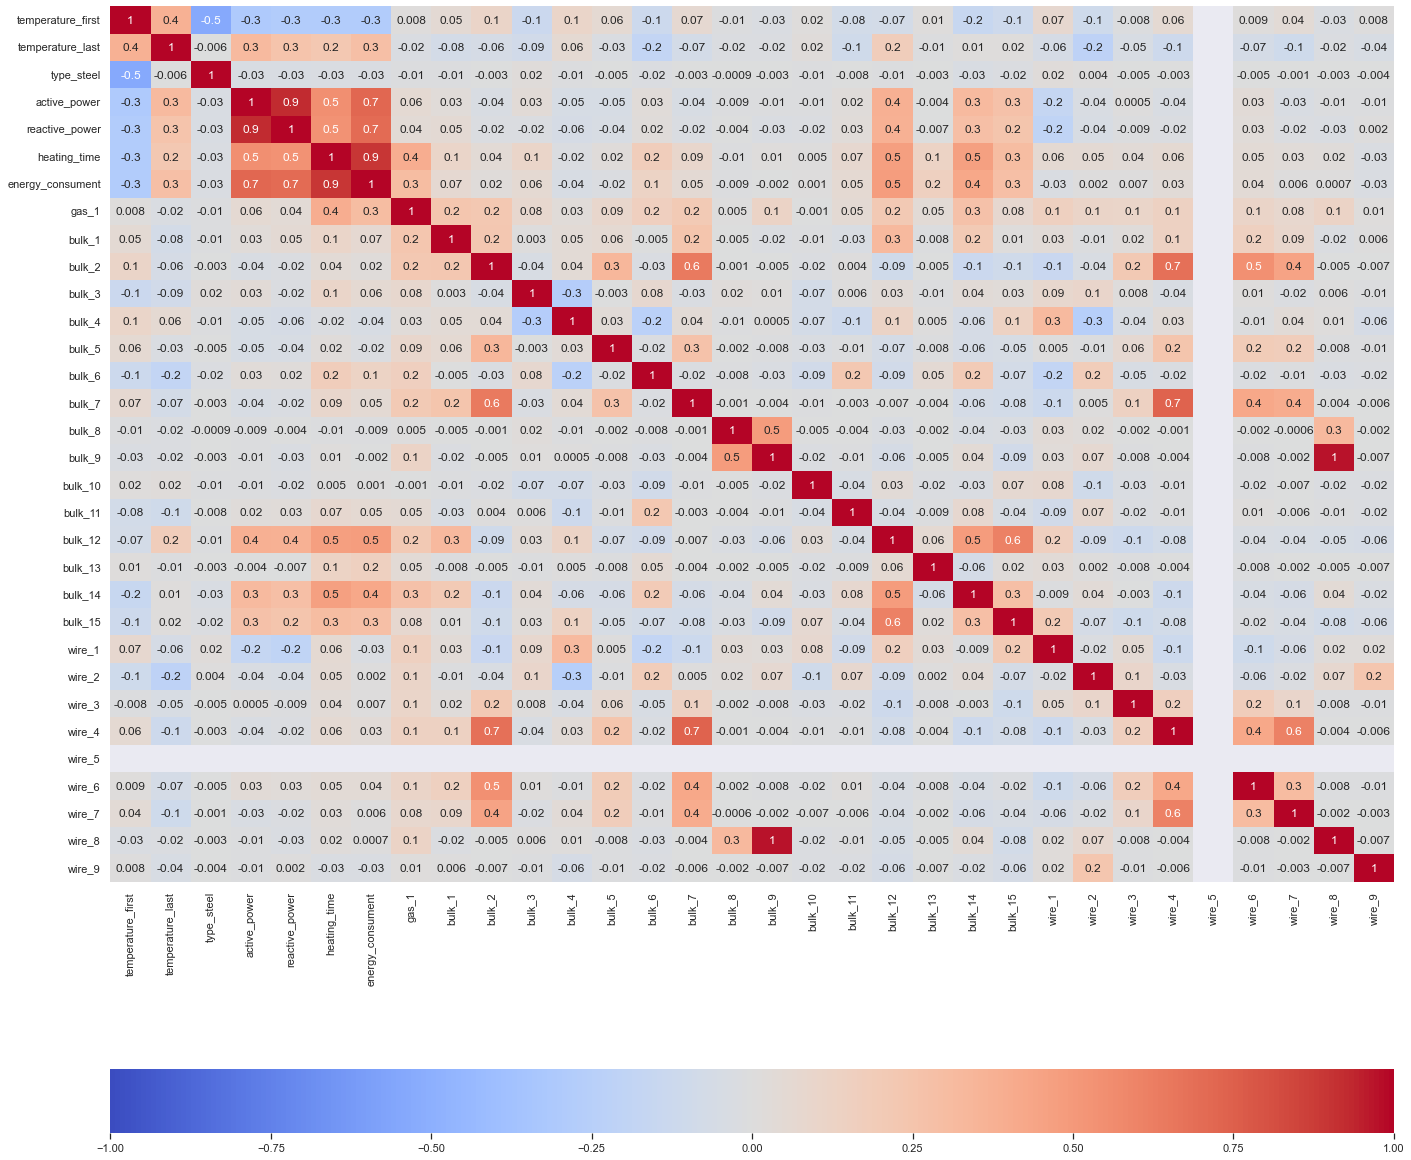

In [77]:
sns.set(rc = {'figure.figsize':(23,23)})
sns.heatmap(summary_table.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', fmt ='.1g',
            cbar_kws= {'orientation': 'horizontal'})

В нашей сводной таблице есть столбцы, которые сильно между собой коррелируют:
- активная мощность с реактивной мощностью 
- время нагрева и количество потребленной электроэнергии
- wire_8 и bulk_9

Удалим по обному столбцу из каждой пары. А также удалим wire_5, потому, что там нет данных.


In [78]:
summary_table = summary_table.drop(['reactive_power', 'energy_consument', 'wire_8', 'wire_5'], axis =1)

**Вывод**

В этом разделе мы провели первичную предобработку и проанализировали данные. Были достигнуты следубщие результаты:
- наименования столбцов приведено к единому стандарту
- пропуски с таблицах с сухими материалами и проволокой заменены на ноль
- в таблице с данными об электродах удалено аномальное значение
- все таблицы были сгруппированы по номеру партии. Начальное и конечное время процесса выведено в отдельные столбцы
- в таблице с температурой, были удалены все строки, где нет последнего измерения. Строки, где время первого измерения температуры и последнего совпадают, тоже были удалены. Построенная диаграмма размаха выявила наличие возможных выбросов, но без помощи технолога и энергетика, сложно сказать, что это действительно аномальные значения температур. Поэтому в эту же таблицу ввели дополнительный столбик с типом стали: если первоначальная температура выше 1450 градусов, то это тип 0, а если ниже, то тип 1.
- провели объединение таблиц по столбцу с номером партии. Выбрали тип объединения how = 'left'. В качествепервой таблицы, к которой присоединяют все остальные, выбрали таблицу с температурой
- из объединенной таблицы удалили все строки, где время последнего измерения температуры меньше времени других опрераций.
- из сводной таблицы удалили лишние столбцы и перевели номер партии в индекс
- посмотрели корреляцию между признаками. Были обнаружены несколько пар признаков, которые между собой коррелируют очень сильно. Из каждой пары удалили по одному признаку.



Далее мы перейдем к подготовке данных к моделированию: разделение на выборки и масштабирование. А затем непосредственно к самому обучению моделей. У нас задача регрессии и в качестве метрики оценки качества будет использована MAE.

## Модель

### Обучение моделей

В этой части проекта мы обучим такие модели как Линейная регрессия, Случайный лес, CatBoost, LGBM, XGBR. Обучение проведем на стандартных гиперпараметрах с использованием кросс-валидации, а также применим GridSearchCV. Лучшую модель проверим на тестовой выборке. В качестве метрики качества модели будем использовать показатель средней абсолютной ошибки (MAE).

#### Подготовка данных к обучению моделей

Разделим нашу выборку на признаки и целевой признак.

In [79]:
features = summary_table.drop(['temperature_last'], axis=1) #удаление целевого признака 
target = summary_table['temperature_last'] # целевой признак

Для начала нам необходимо разделить данные на две части: на обучающую и тестовую выборки. Обучающая выборка будет вмещать 75% данных. С помощью нее мы будем обучать модель. Вторая выборка - тестовая. Ее размер 25% от общего объема данных. На ней мы будем проверять качество обученной модели.

In [80]:
features_train, features_test, target_train, \
 target_test = train_test_split(features, target, test_size=0.25, random_state=20220809)

In [81]:
print(features_train.shape)
print(target_test.shape)
print(features_train.shape)
print(target_test.shape)

(1740, 27)
(581,)
(1740, 27)
(581,)


Разделение прошло успешно.

Признаки у нас имеют разный диапазон разброса значений. Поскольку многие из моделей, которые мы будем строить чувствительны к масштабу, то проведем масштабирование признаков с помощью StandardScaler. Но сначала, отберем только те столбцы, в которых нужно делать масштабирование. В столбце с типом стали у нас категориальные значения и их масштабировать не нужно.

In [82]:
numeric = features_train.columns.tolist()
numeric.remove('type_steel')
print(numeric)

['temperature_first', 'active_power', 'heating_time', 'gas_1', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_6', 'wire_7', 'wire_9']


In [83]:
pd.options.mode.chained_assignment = None

numeric = numeric

scaler = StandardScaler()
scaler.fit(features_train[numeric]) 
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Для удобства создадим свой собственный scorer, по которому мы будем оценивать модели. Поскольку мы создали оценку качества, которая должна стремится к минимуму, добавим параметр greater_is_better=False

In [84]:
mae_score = make_scorer(mean_absolute_error, greater_is_better=False) 

#### Линейная регессия

In [85]:
%%time
model_lr = LinearRegression() # линейная регрессия 
lr_score = cross_val_score(model_lr, features_train, target_train,
                                           scoring = mae_score, cv = 5).mean()
print('Линейная регрессия (быстрый тест):')
print('MAE : {:.2f} '.format(-lr_score))

Линейная регрессия (быстрый тест):
MAE : 7.57 
Wall time: 66 ms


Линейная регрессия дала достаточно высокий показатель MAE = 7,57. Но обучилась модель очень быстро.

#### Случайный лес

In [86]:
%%time
model_rfr = RandomForestRegressor(random_state=20220809) # случайный лес 
mae_rfr_score = cross_val_score(model_rfr, features_train, target_train,
                                                scoring = mae_score, cv = 5).mean()

print('Случайный лес (быстрый тест):')
print('MAE : {:.2f} '.format(-mae_rfr_score))

Случайный лес (быстрый тест):
MAE : 6.47 
Wall time: 3.64 s


Случайный лес на стандартных гиперпараметрах дал показатель MAE = 6,47.

In [87]:
%%time

clf_rfr = RandomForestRegressor(random_state=20220809) # # случайный лес с подбором гиперпараметров
parametrs = { 'n_estimators': range (10, 161, 10),
              'max_depth': range (1,16, 1)
            }
grid_rfr  = GridSearchCV(clf_rfr , parametrs, cv = 5, scoring = mae_score)
grid_rfr.fit(features_train, target_train)
print(grid_rfr.best_params_)

mae_grid_rfr_score = grid_rfr.best_score_
print('Случайный лес (с подбором гиперпараметров):')
print('MAE : {:.2f} '.format(-mae_grid_rfr_score))

{'max_depth': 12, 'n_estimators': 60}
Случайный лес (с подбором гиперпараметров):
MAE : 6.44 
Wall time: 7min 19s


Случайный лес с подбором гиперпараметров, с помощью  GridSearchCV дал показатель MAE = 6,44. Но обучение продолжалось более 7 минут. 

#### CatBoostRegressor

In [88]:
%%time

model_c = CatBoostRegressor(random_state=20220809, loss_function='MAE') # CatBoost

mae_cat_score = cross_val_score(model_c, features_train, target_train,
                                                scoring = mae_score, cv = 5, verbose=50).mean()


print('CatBoost (быстрый тест):')
print('MAE: {:.2f}'.format(- mae_cat_score))


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] START .....................................................................
0:	learn: 9.6968668	total: 125ms	remaining: 2m 5s
1:	learn: 9.5901183	total: 128ms	remaining: 1m 4s
2:	learn: 9.5079548	total: 131ms	remaining: 43.4s
3:	learn: 9.4061776	total: 133ms	remaining: 33.1s
4:	learn: 9.3118752	total: 135ms	remaining: 26.9s
5:	learn: 9.2138301	total: 137ms	remaining: 22.7s
6:	learn: 9.1276673	total: 139ms	remaining: 19.7s
7:	learn: 9.0184512	total: 141ms	remaining: 17.5s
8:	learn: 8.9635975	total: 143ms	remaining: 15.8s
9:	learn: 8.9154168	total: 145ms	remaining: 14.4s
10:	learn: 8.8550093	total: 147ms	remaining: 13.2s
11:	learn: 8.7489656	total: 149ms	remaining: 12.3s
12:	learn: 8.6908152	total: 151ms	remaining: 11.5s
13:	learn: 8.6021220	total: 153ms	remaining: 10.8s
14:	learn: 8.5518806	total: 155ms	remaining: 10.2s
15:	learn: 8.4739290	total: 157ms	remaining: 9.63s
16:	learn: 8.4217324	total: 158m

CatBoost на стандартных гиперпараметрах дал показатель MAE = 6,11, что пока лучший результат. Далее постараемся подобрать гиперпараметры, чтобы слелать еще меньше MAE.

In [89]:
%%time

model_cat = CatBoostRegressor(random_state=20220809)
parametrs = {'depth': range (3, 10, 1),
            'iterations': range (100, 651, 100),
             'learning_rate': [0.03]
            }

grid_cat = GridSearchCV(model_cat, parametrs, cv = 7, scoring = mae_score)
grid_cat.fit(features_train, target_train, verbose=50)
print(grid_cat.best_params_)

mae_grid_cat_score = grid_cat.best_score_
print('CatBoost:')
print('MAE: {:.2f}'.format(- mae_grid_cat_score))

0:	learn: 15.4488506	total: 19.6ms	remaining: 1.94s
50:	learn: 10.7532310	total: 52.3ms	remaining: 50.2ms
99:	learn: 9.3445157	total: 82.4ms	remaining: 0us
0:	learn: 15.7831162	total: 17.7ms	remaining: 1.75s
50:	learn: 10.7957829	total: 50.4ms	remaining: 48.5ms
99:	learn: 9.3798043	total: 82.9ms	remaining: 0us
0:	learn: 15.8578888	total: 5.11ms	remaining: 506ms
50:	learn: 10.9078651	total: 36.5ms	remaining: 35ms
99:	learn: 9.4620115	total: 66.6ms	remaining: 0us
0:	learn: 16.0791443	total: 13.7ms	remaining: 1.36s
50:	learn: 10.9712967	total: 49.4ms	remaining: 47.5ms
99:	learn: 9.4765821	total: 84ms	remaining: 0us
0:	learn: 15.9160690	total: 3.6ms	remaining: 357ms
50:	learn: 10.9842691	total: 37.9ms	remaining: 36.4ms
99:	learn: 9.4822587	total: 70.4ms	remaining: 0us
0:	learn: 16.0084000	total: 15.5ms	remaining: 1.54s
50:	learn: 10.9581205	total: 47.1ms	remaining: 45.3ms
99:	learn: 9.4791284	total: 77.4ms	remaining: 0us
0:	learn: 15.5078748	total: 28.8ms	remaining: 2.85s
50:	learn: 10.740

CatBoost с подбором гиперпараметров дал показатель MAE = 6,07. Обучение шло, чуть больше 6 минут.

#### LGBMRegressor

In [90]:
%%time
       
model_l = LGBMRegressor(random_state=20220809)           
mae_LGBM_score =cross_val_score(model_l, features_train, target_train,
                                      scoring = mae_score, cv = 5).mean()

print('LGBMRegressor (быстрый тест):')
print('MAE: {:.2f}'.format(-mae_LGBM_score))

LGBMRegressor (быстрый тест):
MAE: 6.41
Wall time: 492 ms


LGBM на стандартных гиперпараметрах дал показатель MAE = 6,41

In [91]:
%%time

est_list = []
depth_list = []
for est in range(1, 201, 10):
    est_list.append(est) 
for depth in range(5, 16, 3):
        depth_list.append(depth)
     
    
params = {'max_depth': depth_list, 
          'n_estimators': est_list 
              }
model_lgbm = LGBMRegressor(random_state=20220809)
            
grid_lgbm = GridSearchCV(model_lgbm, params, cv = 5, scoring = mae_score)
grid_lgbm.fit(features_train, target_train)

print(grid_lgbm.best_params_)
print()

mae_grid_LGBM_score = grid_lgbm.best_score_
print('LGBMRegressor (с подбором гиперпараметров):')
print('MAE: {:.2f}'.format(- mae_grid_LGBM_score))

{'max_depth': 5, 'n_estimators': 71}

LGBMRegressor (с подбором гиперпараметров):
MAE: 6.29
Wall time: 27.4 s


LGBM с подбором гиперпараметров дал показатель MAE = 6,29. Обучение шло достаточно быстро - всего 27 секунд. 

#### XGBRegressor

In [92]:
%%time

model_x = XGBRegressor(random_state=20220809)
mae_XGB_score =cross_val_score(model_x, features_train, target_train,
                                      scoring = mae_score, cv = 5).mean()          

print('XGBRegressor (быстрый тест):')
print('MAE: {:.2f}'.format(-mae_XGB_score))


XGBRegressor (быстрый тест):
MAE: 6.70
Wall time: 764 ms


XGB на стандартных гиперпараметрах дал показатель MAE = 6,70

In [93]:
%%time
   
params = {'max_depth': range (5, 16, 5), 
          'n_estimators': range (0, 151, 20)
         }

model_xgb = XGBRegressor(random_state=20220809)
grid_xgb = GridSearchCV(model_xgb, params, cv = 5, scoring = mae_score)
grid_xgb.fit(features_train, target_train)
print(grid_xgb.best_params_)
print()          
          
mae_grid_XGB_score = grid_xgb.best_score_
print('XGBRegressor (с подбором гиперпараметров):')
print('MAE: {:.2f}'.format(-mae_grid_XGB_score))

{'max_depth': 5, 'n_estimators': 40}

XGBRegressor (с подбором гиперпараметров):
MAE: 6.43
Wall time: 19 s


XGB с подбором гиперпараметров дал показатель MAE = 6,43. Обучение шло достаточно быстро - всего 19 секунд.

Для удобства, вседем все показатели MAE в одну таблицу.

In [94]:
score_data = {'MAE': [-lr_score, -mae_rfr_score, -mae_grid_rfr_score, - mae_cat_score,
                         -mae_grid_cat_score, -mae_LGBM_score, - mae_grid_LGBM_score, -mae_XGB_score, -mae_grid_XGB_score]
                          }
score_df = pd.DataFrame(score_data, index = ['Линейная регрессия', 'Случайный лес',                                             
                                             'Случайный лес c подбором гиперпараметров','CatBoostRegressor',
                                             'CatBoostRegressor с подбором гиперпараметров', 'LGBMRegressor',
                                             'LGBMRegressor с подбором гиперпараметров',
                                             'XGBRegressor', 'XGBRegressor с подбором гиперпараметров'])
score_df['MAE'] = round(score_df['MAE'],2)
print('Результаты MAE моделей')
display(score_df)

Результаты MAE моделей


,MAE
Линейная регрессия,7.57
Случайный лес,6.47
Случайный лес c подбором гиперпараметров,6.44
CatBoostRegressor,6.11
CatBoostRegressor с подбором гиперпараметров,6.07
LGBMRegressor,6.41
LGBMRegressor с подбором гиперпараметров,6.29
XGBRegressor,6.70
XGBRegressor с подбором гиперпараметров,6.43


Лучшей моделью у нас является CatBoostRegressor с подбором гиперпараметров, а хуже всего отработала Линейная регрессия. При этом дольше всех обучались Случайный лес с подбором гиперпараметров и CatBoost с подбором гиперпараметров. В случае, когда данных будет значительно больше, придется делать выбор: пожертвовав немного качеством -сэкономить время, или все же качество должно быть на первом месте.

In [95]:
model_c = CatBoostRegressor(random_state=20220809, loss_function='MAE')
model_c.fit(features_train, target_train)

0:	learn: 9.8094645	total: 15.2ms	remaining: 15.2s
1:	learn: 9.7289902	total: 18ms	remaining: 8.97s
2:	learn: 9.6211784	total: 20.4ms	remaining: 6.79s
3:	learn: 9.5403753	total: 22.9ms	remaining: 5.7s
4:	learn: 9.4648052	total: 25.4ms	remaining: 5.06s
5:	learn: 9.3586900	total: 28.3ms	remaining: 4.68s
6:	learn: 9.3119550	total: 30.8ms	remaining: 4.36s
7:	learn: 9.2509130	total: 33.1ms	remaining: 4.11s
8:	learn: 9.1611324	total: 35.4ms	remaining: 3.9s
9:	learn: 9.1016292	total: 38ms	remaining: 3.76s
10:	learn: 9.0293044	total: 40.5ms	remaining: 3.64s
11:	learn: 8.9507517	total: 43.2ms	remaining: 3.55s
12:	learn: 8.8800075	total: 45.4ms	remaining: 3.45s
13:	learn: 8.7999075	total: 47.6ms	remaining: 3.35s
14:	learn: 8.7356107	total: 49.6ms	remaining: 3.26s
15:	learn: 8.6750024	total: 51.7ms	remaining: 3.18s
16:	learn: 8.6024403	total: 53.9ms	remaining: 3.12s
17:	learn: 8.5618550	total: 56.1ms	remaining: 3.06s
18:	learn: 8.5155610	total: 58.4ms	remaining: 3.01s
19:	learn: 8.4505072	total: 

Далее мы посмотрим влияние различных признаков на качество модели CatBoost. Для этого используем SHAP.

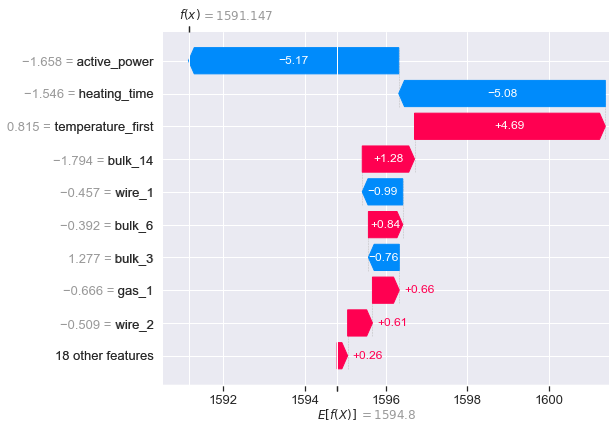

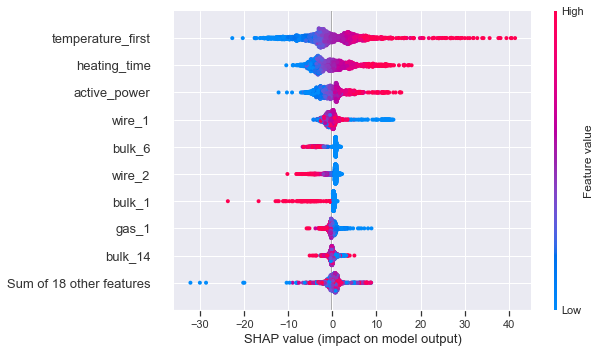

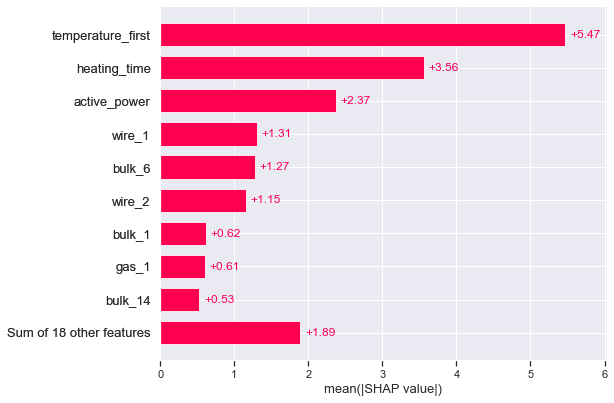

In [96]:
explainer = shap.Explainer(model_c)
shap_values = explainer(features_train)


shap.plots.waterfall(shap_values[0])
shap.plots.beeswarm(shap_values)
shap.plots.bar(shap_values)

Наибольшее влияние оказывают показатель первой температуры, время нагрева и активная мощность. И действительно -это ключевые показатели.


**Вывод**

В этом разделе мы обучили несколько моделей и оценили их качество с помощью MAE. Нашей целью было предсказывать конечную температуры при обработке стали. Мы обучили Линейную регрессию, Случайный лес, CatBoost, LGBM, XGBR. Обучение проведем на стандартных гиперпараметрах с использованием кросс-валидации, а также применим GridSearchCV. Лучший показатель MAE - 6,07 дала модель CatBoost с подбором гиперпараметров, хотя ее обучение проходило достаточно долго (дольше только обучался Случайный лес с подбором гиперпараметров).

### Проверка качества лучшей модели

Проверим качество нашей лучшей модели на тестовой выборке.

In [97]:
predicted_test = grid_cat.predict(features_test)
mae_test = mean_absolute_error(target_test, predicted_test)
print('MAE: {:.2f} '.format(mae_test))


MAE: 5.85 


Показатель средней абсолютной ошибки даже меньше, чем на обучающей выборке - всего 5,85.

## Общий вывод 

В данной работе у нас стояла задача сделать модель, которая будет предсказывать температуру стали, перед тем как она поступит в машину непрерывной заливки. 

В процессе работы мы выполнили следующие этапы:
- посмотрели общую информацию о предоставленных данных и выявили неточности и аномалии. 
- провели предобработку данных
- свели все данные в единую таблицу и проанализировали ее. По итогу удалили лишние столбцы
- обучили Линейную регрессию, Случайный лес, CatBoost, LGBM, XGBR. Обучение провели на стандартных гиперпараметрах с использованием кросс-валидации, а также с применением GridSearchCV. Сравнили результаты. Выбрали лучшую модель.
- посмотрели, как разные признаки влияют на качество модели.
- проверили качество лучшей модели на тестовой выборке



Лучшей моделью выбрана CatBoost с подбором гиперпараметров. MAE на тестовой выборке 5,85.

## Отчет по проекту

Металлургический комбинат ООО «Так закаляем сталь» решил оптимизировать производственные расходы, путем уменьшения потребления электроэнергии на этапе обработки стали.

Целью нашего проекта было построить модель, которая предскажет температуру стали в конце обработки, перед тем как она поступит машину непрерывной заливки.

В нашем распоряжении были следующие данные: 
- данные об электродах (начальное и конечное время нагрева и мощность по каждому этапу и каждой парти
- данные о добавленных присадках (объем сыпучих материалов и проволоки, а также время их добавления в расплавленную сталь.
- данные о продувки газом
- результаты изменения температуры на разных стадиях обработки и время, когда проводилось измерение.

Для решения задачи мы разработали следующий план действий:
1.	Загрузка и первичный осмотр данных. Выявление пропусков, дубликатов, проверка типов данных и просмотр первичных статистических данных на необработанных таблицах. 
2.	Проведение предобработки: замена пропусков в таблицах при необходимости. Группировка данных по номеру партии. Просмотр выбросов в таблице с температурой.
3.	Подготовка сводной таблицы для последующего моделирования. Разделение таблицы на две выборки: тестовую и обучающую и выделение целевого признака.
4.	Обучение нескольких моделей (4-6). В процессе обучения, постараться подобрать оптимальные гиперпараметры и применить кросс-валидацию.
5.	Оценить качество моделей на тестовой выборке.

В работе нам удалось реализовать все пункты нашего плана.

1).	При первичном осмотре данных мы обнаружили:
- все таблицы требуют приведения наименования столбцов к единому формату (визуальный осмотр).
- дубликатов мы не обнаружили (duplicated().sum())
- количество уникальных номеров партий в таблицах разное (len(«столбец».unique())
- данные, кроме таблиц во временем добавления сыпучих материалов и проволоки, имеют положительную скощенность (describe() – медиана меньше среднего)
- в таблицах с мощностями и температурами явно есть выбросы, которые нужно будет обработать перед построением модели (визуальный осмотр границ 1-го и 3-го квартиля и максимума и минимума)
- не для всех партий есть измерение температуры по завершению процесса. Такие партии нужно будет удалить. Как в принципе и те, у которых вообще нет измерений температуры. (usna().sum())
- в таблицах с присадками также есть пропуски, обусловленные тем, что не все материалы добавляют на всех этапах. 
- поскольку мы сразу при загрузке определили, что даты и время должны загружаться в формате datetime64, то корректировки типа данных в таблицах не требуется.

2). На втором этапе (на этапе предобработки) мы сделали следующее:
- привели названия столбцов к единому виду
- заменили пропуски в таблицах с данными о сыпучих материалах и проволоке на ноль.

Далее мы работали с каждой таблицей отдельно.

В данных об электродах мы удалили аномальное значение реактивной мощности (-715). Есть предположение, что ошибка при пересчете единиц измерения и должно было быть 0,715 или -0,715. Но поскольку нет возможности получить дополнительную информацию от энергетика, эту строку мы удалили. Далее мы посчитали суммарное время нагрева по каждой строке. И рассчитали количество потребленной электроэнергии. Данные сгруппировали по номеру партии так, чтобы у нас осталось начальное и конечное время нагрева, средняя активная и реактивная мощности, суммарное время нагрева и суммарное количество затраченной электроэнергии. Затем мы построили диаграмму размаха и посмотрели характерный разброс значений. Часть данных на диаграмме выглядит как выбросы, но опять же не имея дополнительной информации от энергетика, мы удалять эти значения не стали. Построив диаграмму размаха для количества потребленной электроэнергии, мы также обнаружили несколько выбросов (количество электроэнергии более 4000). Посмотрев поближе эти строки, мы обнаружили, что мощность находится в нормальных пределах, но время нагрева очень большое. Далее, посмотрев эти сроки в таблице с температурами, аномальных значений по начальной и конечной температуре не увидели. Эти строки решено было оставить.

Следом мы обработали таблицы с данными об объеме сыпучих материалов и проволоки, а также по времени их добавления. Данные об объемах мы сгруппировали по номеру партии с помощью метода groupby(), посчитав сумму по каждой присадке. В связи с тем, что нам нужно было, чтобы последний замер температуры был произведен по окончанию производственного процесса, возникла необходимость проверить время последнего добавления сухих материалов и проволоки. В итоговой таблице в последствии, мы отбирали только те партии, где время замера температуры больше времени последнего нагрева, и последнего добавления материалов. Для этого нам пришлось найти последнее время добавления материалов по каждой строке и сделать отдельные таблицы, в которых всего по два столбца: номер партии и последнее время добавления присадок.

С данными о замерах температуры мы сделали следующее:
- мы удалили сроки, где нет данных о температуре
- сгруппировали данные, таким образом, чтобы у нас появились столбцы со временем первого и последнего измерения, первая и последняя температуры
- удалили партии, где время первого замера равно времени последнего замера
- построили диаграмму размаха для начальных и конечных температур. Обнаружили данные похожие на выбросы. Поскольку технолог нам не доступен, я поискала информацию и интернете и нашла, что у разных видов стали, может быть разная температура плавления. В связи с этим было принято решение, ввести в таблицу дополнительный признак, который бы разделял стали по видам (0- обычная сталь, 1- сталь температурой плавления ниже 1450 градусов)

3). В следующем этапе мы сводили данные в одну общую таблицу. Для этого в качестве первой использовали таблицу с температурой, поскольку именно в ней находится целевой признак. Тип присоединения применили how = 'left'.

Создали список партий, где последнее время измерения температуры не является последней итерацией в процессе. Эти партии удалили.

После этого мы удалили все столбцы с указанием времени операций, поскольку эти столбцы не значимы для модели. В столбцах с присадками пропуски, образовавшиеся при объединении таблиц заменили на ноль и создали список партий, в которых нет добавления присадок. Такие партии мы тоже удалили.

С помощью тепловой карты из библиотеки seaborn и метода corr() посмотрели корреляцию между признаками и выявили несколько пар столбцов, которые сильно между собой коррелируют. Из каждой пары удалили по одному. На удаление пошли реактивная мощность, количество электроэнергии, 'wire_8'.  'wire_5' мы удалили, потому что там нет данных.

4). Далее мы приступили к основной части проекта, в которой закончили подготовку признаков и обучили такие модели как Линейная регрессия, Случайный лес, CatBoost, LGBM, XGBR. 

Здесь мы разделили данные на признаки и целевой признак. Провели разделение на обучающую и тестовую выборки с помощью train_test_split(). Провели масштабирование признаков с помощью StandardScaler, поскольку многие из моделей, которые мы запланировали построить чувствительны к масштабу. 
Мы решали задачу регрессии. В качестве метрики качества использовали среднюю абсолютную ошибку (MAE).

Обучили такие модели как Линейная регрессия, Случайный лес, CatBoost, LGBM, XGBR. Обучение провели на стандартных гиперпараметрах с использованием кросс-валидации, а также применили GridSearchCV. При подборе гиперпараметров руководствовалась следующей логикой: поскольку выборка у нас не большая, то количество деревьев  в Случайном лесу, CatBoost, LGBM, XGBR не должно быть очень большим. Пришлось несколько раз менять диапазоны для значений гиперпараметров. Также хотелось найти такие гиперпараметры, которые позволят получить качество моделей лучше, чем при обучении тех же моделей, но на стандартных настройках. 

Лучшей моделью у нас является CatBoostRegressor с подбором гиперпараметров, а хуже всего отработала Линейная регрессия. При этом дольше всех обучались Случайный лес с подбором гиперпараметров и CatBoost с подбором гиперпараметров.


Линейная регрессия:	MAE-7.57,гиперпараметры стандартные, примерное время обучения -66 ms

Случайный лес: MAE-6.47, гиперпараметры стандартные, примерное время обучения -3.64 s

Случайный лес c подбором гиперпараметров: MAE-6.44, лучшие гиперпараметры -{'max_depth': 12, 'n_estimators': 60}, примерное время обучения -7min 19s

CatBoostRegressor:	MAE-6.11	стандартные	примерное время обучения -10.4 s

CatBoostRegressor с подбором гиперпараметров: MAE-6.07, лучшие гиперпараметры -{'depth': 6, 'iterations': 600, 'learning_rate': 0.03}, примерное время обучения -6min 5s

LGBMRegressor:	MAE-6.41, стандартные гиперпараметры, примерное время обучения -492 ms

LGBMRegressor с подбором гиперпараметров:	MAE-6.29, лучшие гиперпараметры -{'max_depth': 5, 'n_estimators': 71}, примерное время обучения -27.4 s

XGBRegressor:	MAE-6.70, стандартные гиперпараметры, примерное время обучения -764 ms

XGBRegressor с подбором гиперпараметров:	MAE-6.43, лучшие гиперпараметры -{'max_depth': 5, 'n_estimators': 40}, примерное время обучения -19 s

Дополнительно, мы с помощью SHAP посмотрели, как влияют различные признаки на качество модели. Наибольшее влияние оказывают показатель первой температуры, время нагрева и активная мощность. И действительно -это ключевые показатели.

5). Провели проверку качества нашей лучшей модели CatBoost с подбором гиперпараметров на тестовой выборке. MAE на тестовой выборке 5,85.
